In [1]:
# importing tools 
import s3fs
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt 
import math
#for removing warnings
import warnings

In [2]:
# open the data with s3fs from the databucket 
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })

In [3]:
fsg.ls('data/PC-data')

['data/PC-data/bathym.nc',
 'data/PC-data/uv.nc',
 'data/PC-data/uvar.nc',
 'data/PC-data/vvar.nc']

In [4]:
# choosing all the data in the path  
data_path = 's3://data/PC-data/*.nc'

In [5]:
remote_files = fsg.glob(data_path)
remote_files

['data/PC-data/bathym.nc',
 'data/PC-data/uv.nc',
 'data/PC-data/uvar.nc',
 'data/PC-data/vvar.nc']

In [10]:
fileset = [fsg.open(file) for file in remote_files]

In [11]:
#open the dataset 
dset = xr.open_mfdataset(fileset, combine='by_coords',compat='override')
dset

<xarray.Dataset>
Dimensions:                        (depth: 75, x: 1580, y: 1801)
Coordinates:
  * depth                          (depth) float32 0.5058 1.556 ... 5.902e+03
    time_centered                  object ...
    time_counter                   object ...
    nav_lat                        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon                        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    __xarray_dataarray_variable__  (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    mbathy                         (y, x) int16 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    vomecrty                       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    vozocrtx                       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>

In [12]:
# rename variabel
dset = dset.rename({'__xarray_dataarray_variable__' : 'vel'})
dset

<xarray.Dataset>
Dimensions:        (depth: 75, x: 1580, y: 1801)
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  object ...
    time_counter   object ...
    nav_lat        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    vel            (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    mbathy         (y, x) int16 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    vomecrty       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    vozocrtx       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>

In [31]:
# Smoothen data, over every tenth point in both x and y direction, for all the data
vvar = dset.vomecrty.rolling(y=10).mean()
uvar = dset.vozocrtx.rolling(x=10).mean()
uv = dset.vel.rolling(x=10).mean()
uv = uv.rolling(y=10).mean()

In [32]:
# List of x,y elements that I wanna plot over later 
# should be of the same size as the scaling/smoothening .. have 10 on smoothenig
dx = 20
dy = 20

In [33]:
# Making empty list with size as data-points 
jmax, imax = uv[0].shape #fetches the max value in j and i direction 
i_list = np.arange(0,imax,dx)
j_list = np.arange(0,jmax,dy)

In [34]:
# Making the covmatrix and finding the eigenvalues and eigenvectors
# list of all the points for the PC-crosses
'Dont remember how I got to this number, so dont know how to change the number of points in each PC'
PC11 = np.zeros(3379)
PC12 = np.zeros(3379)
PC21 = np.zeros(3379)
PC22 = np.zeros(3379)
y = np.zeros(3379)
x = np.zeros(3379)
indx = 0


In [35]:
# to get the loop to run faster
uvy = np.array(uv.y.values)
uvx = np.array(uv.x.values)


In [36]:
# chooseing a level to look at 
level = 7
depth = dset.depth[level].values
print(depth)

9.82275


In [37]:
uvar0 = np.array(uvar[level,:,:].values)
vvar0 = np.array(vvar[level,:,:].values)
uvvel = np.array(uv[level,:,:].values)

In [38]:
warnings.filterwarnings('ignore')
for i in i_list:
    for j in j_list:
        covm = np.array([[uvar0[j,i],uvvel[j,i]],
        [uvvel[j,i],vvar0[j,i]]],dtype=float)
        if np.isnan(covm).any():
            continue
        else:
            values, vectors = np.linalg.eig(covm)
            PC11[int(indx)] = vectors[0,0]*np.sqrt(values[0])
            PC12[int(indx)] = vectors[1,0]*np.sqrt(values[0])
            PC21[int(indx)] = vectors[0,1]*np.sqrt(values[1])
            PC22[int(indx)] = vectors[1,1]*np.sqrt(values[1])
            y[int(indx)] = uvy[j]
            x[int(indx)] = uvx[i]
            indx = indx + 1

In [40]:
# converting to np.arrays
PC11 = np.array(PC11,dtype=float)
PC12 = np.array(PC12,dtype=float)
PC21 = np.array(PC21,dtype=float)
PC22 = np.array(PC22,dtype=float)
y = np.array(y,dtype=float)
x = np.array(x,dtype=float)

# funcktion for rolling mean 
def running_mean(x, N):
    out = np.zeros_like(x, dtype=np.float64)
    dim_len = x.shape[0]
    for i in range(dim_len):
        if N%2 == 0:
            a, b = i - (N-1)//2, i + (N-1)//2 + 2
        else:
            a, b = i - (N-1)//2, i + (N-1)//2 + 1

        #cap indices to min and max indices
        a = max(0, a)
        b = min(dim_len, b)
        out[i] = np.mean(x[a:b])
    return out

PC11 = running_mean(PC11, 10)
PC12 = running_mean(PC12, 10)
PC21 = running_mean(PC21, 10)
PC22 = running_mean(PC22, 10)

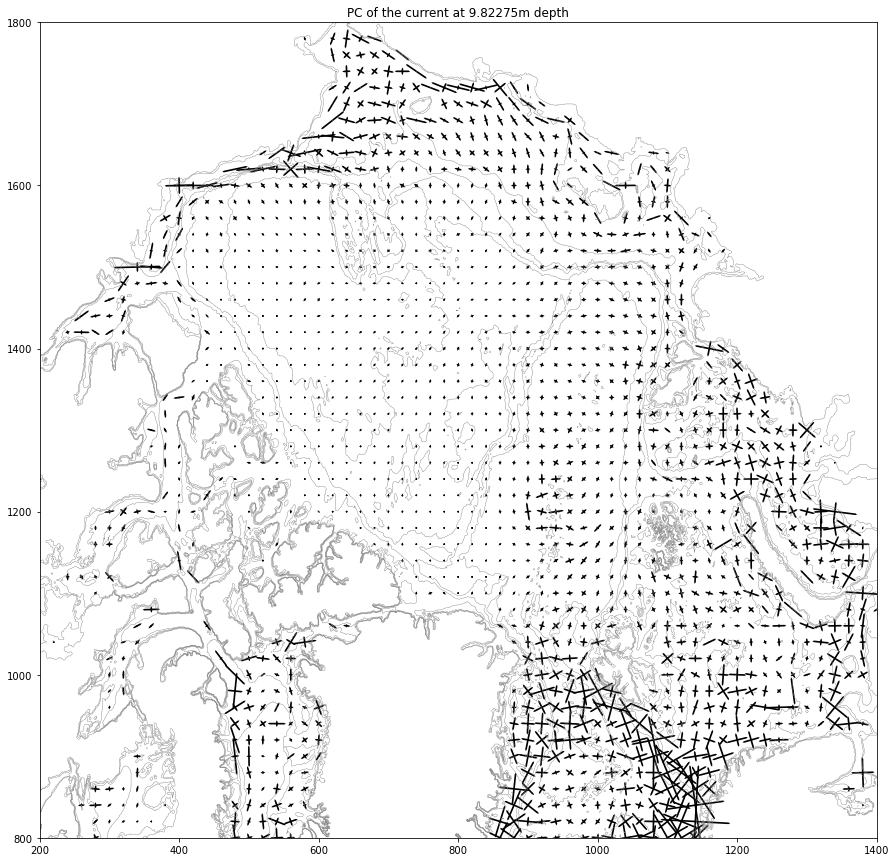

In [42]:
# Plot
fig, ax = plt.subplots(1,1,figsize=(15,15))
plt.title(f'PC of the current at ' + str(depth) + 'm depth')
cmap = plt.get_cmap('magma_r')
ax.contour(dset.mbathy, colors='grey',levels=8, linewidths=0.4)
ax.quiver( x[::1], y[::1], PC11[::1], PC12[::1], 
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=4)
ax.quiver(x[::1], y[::1], -PC11[::1], -PC12[::1],
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=4)
ax.quiver( x[::1], y[::1], PC21[::1], PC22[::1],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=4)
ax.quiver( x[::1], y[::1], -PC21[::1], -PC22[::1],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=4)
ax.set_xlim(200,1400)
ax.set_ylim(800,1800)

plt.show()